# Chapter 5 - Evaluating Risk
## 5.1 Evaluating Covariance Matrix
### Robust Loss Functions for Volatility Estimation
Loss function should measure how close the estimated/forecasted volatility, $\hat{\sigma}_t$ is to the estimated realized volatility $\tilde{\sigma}_t$:

$$\bar{L} = 1/T\sum_{t=1}^TL(\tilde{\sigma}_t^2, \hat{\sigma}_t^2)$$

Two example loss functions:

$$ QLIKE(\hat{\sigma}, r) = 1/T \sum_{t=1}^T \left(\frac{r_t^2}{\hat{\sigma}_t^2} - log\left(\frac{r_t^2}{\hat{\sigma}_t^2}\right)-1 \right) $$
$$ MSE(\hat{\sigma}, r) = 1/T \sum_{t=1}^T \hat{\sigma}_t^2 \left(\frac{r_t^2}{\hat{\sigma}_t^2} - 1\right)^2 $$

QLIKE is the negative log-likelihood (excluding the constant terms). 
QLIKE is skewed, higher loss when the realized vol is smaller than the forecasted vol, so overestimation is penalized more.

In [1]:
import matplotlib.pyplot as plt
import numpy as np

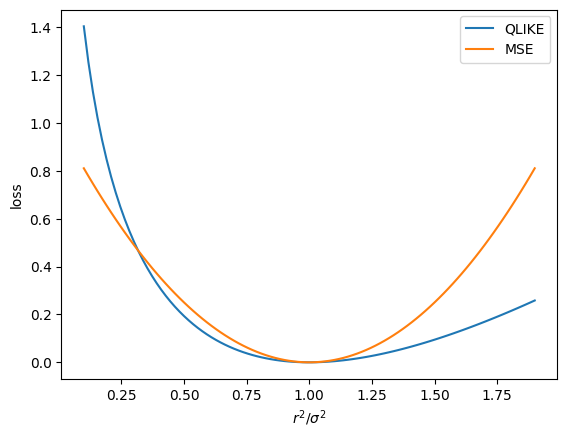

In [21]:
x = np.linspace(0.1, 1.9, 100)
y = x - np.log(x) - 1
y1 = (x-1)**2
plt.plot(x, y, label="QLIKE")
plt.plot(x, y1, label="MSE")
plt.xlabel(f"$r^2/\sigma^2$")
plt.ylabel("loss")
plt.legend()

### Application to Multivariate Returns

To apply the loss functions (QLIKE, MSE) from above to multivariate returns (covariance matrix), we need to convert the estimated covariance matrix to a scalar volatility. Portfolio weight is the connection $\hat{\sigma}_t^2 = w^T\hat{\Omega}_t^2 w$. The following methods center around how the weight vector is generated.

- Average-case Analysis (Procedure 5.1 on page 98):
  - At each iteration
    - generate weights $w$ from a multivariate standard normal distribution, s.t. $w^T1 = 1$. Then uniformly and randomly select a timestamp $s$ for covariance matrix $\Omega_s$ and returns vector $r_s$
    - Calculate loss with either QLIKE, MSE: $L\left[(r_s^Tw)^2, w^T\hat{\Omega}_sw\right]$
    - Accumulate the loss to $L_{tot}$
    - Stop if the cumulated loss converges, i.e. $L / L_{tot} \lt \epsilon_{tol}$
  - Return $L_{tot} / n_{iter}$

- Worst-case under/over-prediction
  - Same procedure as the average-case but decrement the random weight by its gradient (loss function w.r.t weight), step size is inversely proportional to the number of iterations, i.e. smaller gradient update further into the process.

- Leading-Alpha MVO portfolios
  - Rather than picking timestamp and weights randomly. We iterate through the timestamps
    - The weight is calculated using leading returns $\hat{\alpha}_t$ (average over the next $\tau$ timestamps) and $\hat{\Omega}_t$, i.e. $\hat{\Omega}_t^{-1}\hat{\alpha}_t$
    - The loss is calculated using the leading returns, weight from the step above and forecasted covariance matrix.
 
- Distribution likelihood
  - Negative log-likelihood of multivariate zero-mean normal distribution
    $$QDIST = \sum_t\left(r_t^T\hat{\Omega}_{r,t}^{-1}r_t + log|\hat{\Omega}_{r,t}| + nlog(2\pi)\right)$$
  - The function is minimized when the covariance matrix is aligned with the actual returns' distribution.

The average-case, worst-case analysis are limited by the computational intensity, when we need to sample many weights with high dimensions. The leading-alpha analysis tests predictiveness of stategies in the context of portfolios and can easily add controlled randomness to the leading returns. QDIST is completely independent of the methods discussed above, which might add an independent metrics when evaluating the covariance matrix accuracy.

### Exercise 5.1

$$trace(\hat{\Omega}_{r,t}^{-1}r_tr_t^T)=trace(r_t^T\hat{\Omega}_{r,t}^{-1}r_t)=r_t^T\hat{\Omega}_{r,t}^{-1}r_t$$

The last equality is because it's just a scalar. 

For the second term $\hat{\Omega}_{r,t}^{-1}r_t$ and $r_t$ are both vectors, and their outer product creates a rank-1 matrix. Therefore, the determinant is always 0 for $n>1$ since there is at least 1 eigenvalue equal to 0 and determinant is the product of all eigenvalues. The second term is $-\infty$. Needs clarification here.

## Precision Matrix

### Min-Variance

$$\min w^T\hat{\Omega}_r w$$
$$s.t. b^Tw = 1$$

The solution is the weight vector $\hat{w}=w(\hat{\Omega}_r)$, $\hat{w}^T\hat{\Omega}\hat{w} \geq \hat{w}^T\Omega\hat{w}$, equal when the forecasted covariance matrix is the same as the realized cov matrix (perfect estimation). Set $b=r$, the problem becomes the classic MVO, the quality of the cov matrix estimation can be ranked/evaluated by the resulting realized sharpe ratio, i.e. strategy performs better when the covariance matrix is estimated more correctly.

### Mahalanobis Distance

$$d = \sqrt{r^T\Omega_r^{-1}r}$$

$d^2$ follows a chi-squared distribution with n d.o.f. Test

$$\upsilon_t = 1/n_t r_t^T\hat{\Omega}_{r,t}^{-1}r_t$$
$$MALV = var(\upsilon_1, \ldots, \upsilon_T)$$

Lower MALV indicates better precision matrix. This test evaluates the variance of the distance between the estimated covariance matrix and the realized one, and not the distance itself. The volatility tests from above should complement well.